# 量化金融预测

In [86]:
# 导入模块
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
import sklearn.tree as tree
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, mean_squared_log_error
import sys, os, warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [87]:
# 数据导入
train_file = os.listdir('input/train/')
test_file = os.listdir('input/test/')
train = pd.DataFrame()
test = pd.DataFrame()
# 读取训练数据
for file in train_file:
    tmp = pd.read_csv('input/train/'+file)
    tmp['file'] = file
    train = pd.concat([train, tmp], axis=0, ignore_index=True)
# 读取测试数据
for file in test_file:
    tmp = pd.read_csv('input/test/'+file)
    tmp['file'] = file
    test = pd.concat([test, tmp], axis=0, ignore_index=True)

In [88]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687156 entries, 0 to 1687155
Data columns (total 33 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   uuid          1687156 non-null  int64  
 1   date          1687156 non-null  int64  
 2   time          1687156 non-null  object 
 3   sym           1687156 non-null  int64  
 4   n_close       1687156 non-null  float64
 5   amount_delta  1687156 non-null  float64
 6   n_midprice    1687156 non-null  float64
 7   n_bid1        1687156 non-null  float64
 8   n_bsize1      1687156 non-null  float64
 9   n_bid2        1687156 non-null  float64
 10  n_bsize2      1687156 non-null  float64
 11  n_bid3        1687156 non-null  float64
 12  n_bsize3      1687156 non-null  float64
 13  n_bid4        1687156 non-null  float64
 14  n_bsize4      1687156 non-null  float64
 15  n_bid5        1687156 non-null  float64
 16  n_bsize5      1687156 non-null  float64
 17  n_ask1        1687156 non-n

In [89]:
train.head()

,uuid,date,time,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,...,n_ask4,n_asize4,n_ask5,n_asize5,label_5,label_10,label_20,label_40,label_60,file
0,0,0,09:40:03,1,-0.007605,2081.0,-0.009506,-0.011407,0.000222,-0.015209,...,0.003802,0.000162,0.007605,0.000262,1,0,0,0,1,snapshot_sym1_date0_am.csv
1,1,0,09:40:06,1,-0.011407,129268.0,-0.009506,-0.011407,0.000221,-0.015209,...,0.003802,0.000163,0.007605,0.000264,1,0,0,0,1,snapshot_sym1_date0_am.csv
2,2,0,09:40:09,1,-0.007605,76098.0,-0.009506,-0.011407,0.000221,-0.015209,...,0.003802,0.000163,0.007605,0.000265,0,0,0,0,1,snapshot_sym1_date0_am.csv
3,3,0,09:40:12,1,-0.007605,2613280.0,-0.009506,-0.011407,0.000174,-0.015209,...,0.003802,0.000162,0.007605,0.000265,0,0,0,0,1,snapshot_sym1_date0_am.csv
4,4,0,09:40:15,1,-0.011407,327615.0,-0.009506,-0.011407,0.000112,-0.015209,...,0.003802,0.000162,0.007605,0.000265,0,0,0,0,1,snapshot_sym1_date0_am.csv


In [90]:
train.tail()

,uuid,date,time,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,...,n_ask4,n_asize4,n_ask5,n_asize5,label_5,label_10,label_20,label_40,label_60,file
1687151,1994,9,14:49:45,9,0.026085,680336.0,0.025998,0.02591,1.153103e-06,0.025735,...,0.026611,0.000004,0.026786,0.000005,1,1,1,0,0,snapshot_sym9_date9_pm.csv
1687152,1995,9,14:49:48,9,0.026085,123081.0,0.025998,0.02591,9.944617e-07,0.025735,...,0.026611,0.000004,0.026786,0.000005,1,1,1,0,0,snapshot_sym9_date9_pm.csv
1687153,1996,9,14:49:51,9,0.025910,409963.0,0.025998,0.02591,9.236202e-07,0.025735,...,0.026611,0.000004,0.026786,0.000005,1,1,1,0,0,snapshot_sym9_date9_pm.csv
1687154,1997,9,14:49:54,9,0.025910,52742.0,0.025998,0.02591,9.017386e-07,0.025735,...,0.026611,0.000004,0.026786,0.000005,1,1,1,0,0,snapshot_sym9_date9_pm.csv
1687155,1998,9,14:49:57,9,0.025910,316441.0,0.025998,0.02591,6.938639e-07,0.025735,...,0.026611,0.000004,0.026786,0.000005,1,1,1,0,0,snapshot_sym9_date9_pm.csv


In [91]:
train.describe()

,uuid,date,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,n_bsize2,...,n_asize3,n_ask4,n_asize4,n_ask5,n_asize5,label_5,label_10,label_20,label_40,label_60
count,1.687156e+06,1.687156e+06,1.687156e+06,1.687156e+06,1.687156e+06,1.687156e+06,1.687156e+06,1.687156e+06,1.687156e+06,1.687156e+06,...,1.687156e+06,1.687156e+06,1.687156e+06,1.687156e+06,1.687156e+06,1.687156e+06,1.687156e+06,1.687156e+06,1.687156e+06,1.687156e+06
mean,9.990000e+02,2.992299e+01,4.872038e+00,5.700705e-03,4.565713e+05,5.682728e-03,5.120704e-03,1.281423e-04,3.697179e-03,9.180419e-05,...,8.748244e-05,9.323849e-03,8.665281e-05,1.067266e-02,8.538092e-05,1.000289e+00,9.978662e-01,1.000617e+00,9.974015e-01,9.973405e-01
std,5.770617e+02,1.763956e+01,2.901663e+00,2.495315e-02,3.655047e+06,2.492419e-02,2.458427e-02,6.878200e-04,2.464447e-02,1.509490e-04,...,1.575252e-04,2.292584e-02,1.585608e-04,2.319458e-02,1.518221e-04,5.358739e-01,6.278053e-01,5.610704e-01,6.687669e-01,7.214663e-01
min,0.000000e+00,0.000000e+00,1.000000e+00,-1.000000e-01,0.000000e+00,-1.000000e-01,-1.000000e-01,0.000000e+00,-1.000000e-01,0.000000e+00,...,0.000000e+00,-9.741379e-02,0.000000e+00,-9.655172e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.990000e+02,1.500000e+01,2.000000e+00,-8.099282e-03,5.340000e+03,-8.142340e-03,-8.849558e-03,1.760739e-06,-1.038062e-02,3.349435e-06,...,3.187505e-06,-3.802281e-03,3.295881e-06,-2.861230e-03,3.295881e-06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,9.990000e+02,3.000000e+01,4.000000e+00,3.588907e-03,6.799550e+04,2.926752e-03,2.560164e-03,9.252295e-06,7.733952e-04,1.636070e-05,...,1.558775e-05,7.722008e-03,1.610305e-05,9.217391e-03,1.633037e-05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,1.499000e+03,4.500000e+01,8.000000e+00,1.642681e-02,3.505990e+05,1.656289e-02,1.562500e-02,5.777411e-05,1.447301e-02,1.217613e-04,...,9.960530e-05,2.085061e-02,9.998852e-05,2.272727e-02,1.023744e-04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
max,1.998000e+03,6.000000e+01,9.000000e+00,1.002766e-01,3.440177e+09,1.002766e-01,1.002766e-01,1.559218e-02,9.987086e-02,9.185008e-03,...,4.536643e-03,1.002766e-01,4.547569e-03,1.002766e-01,4.616156e-03,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00


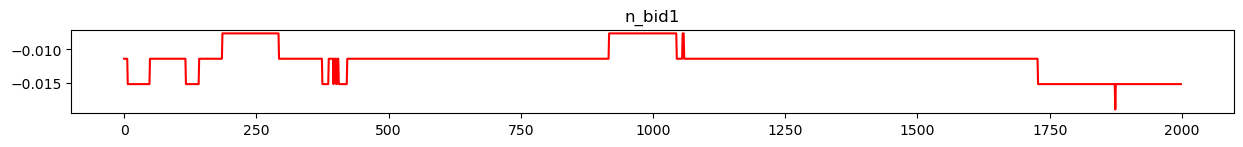

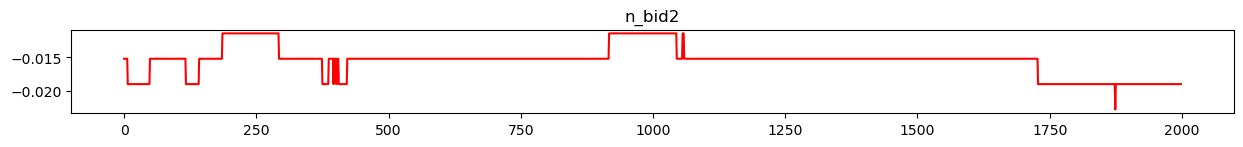

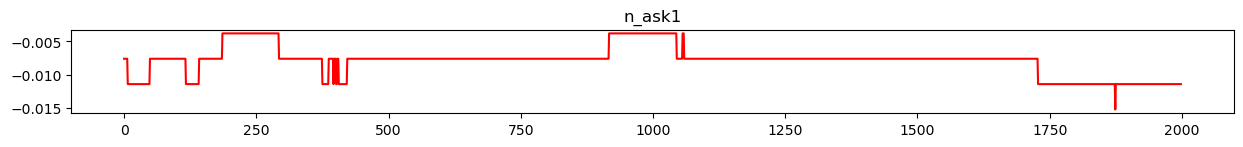

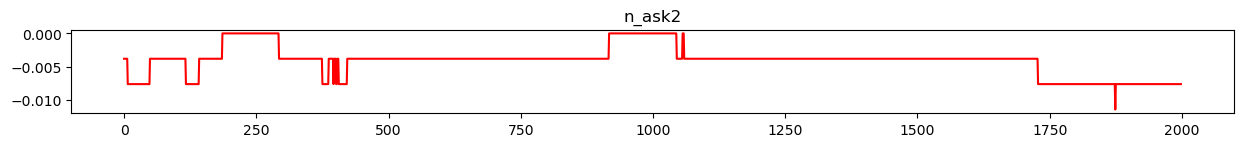

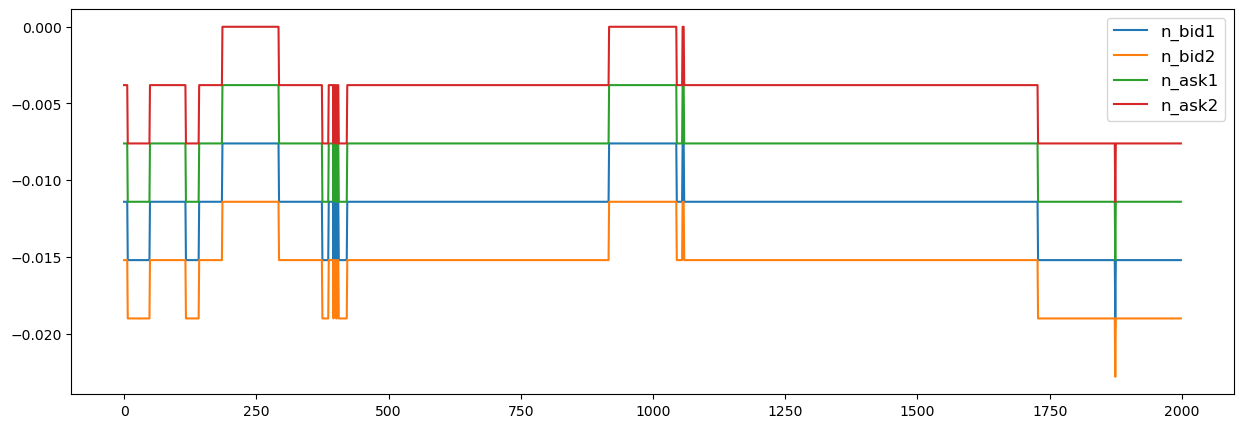

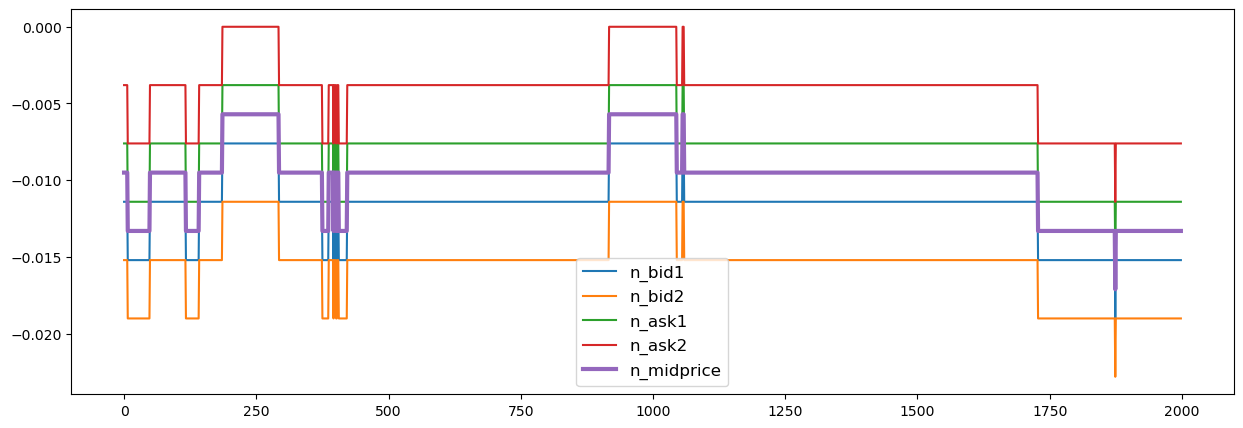

In [92]:
cols = ['n_bid1','n_bid2','n_ask1','n_ask2']
tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[-2000:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
for num, col in enumerate(cols):
    plt.figure(figsize=(15,5))
    plt.subplot(4,1,num+1)
    plt.plot(tmp_df['index'],tmp_df[col], color='red')
    plt.title(col)
plt.show()

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)
plt.legend(fontsize=12)

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)

plt.plot(tmp_df['index'],tmp_df['n_midprice'],label="n_midprice",lw=3)
plt.legend(fontsize=12)

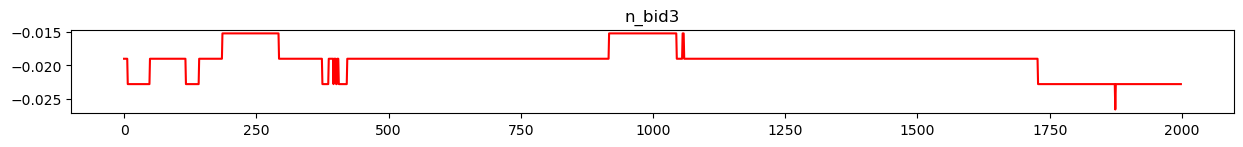

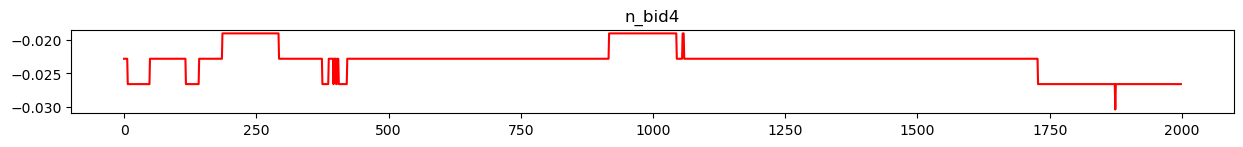

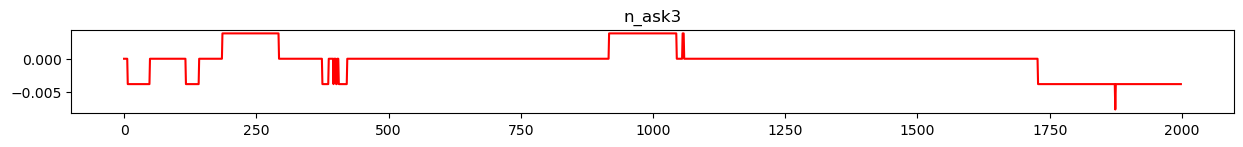

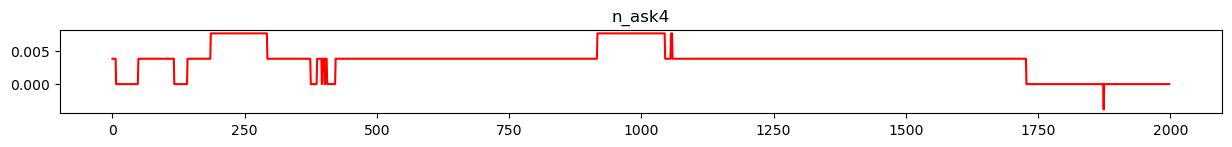

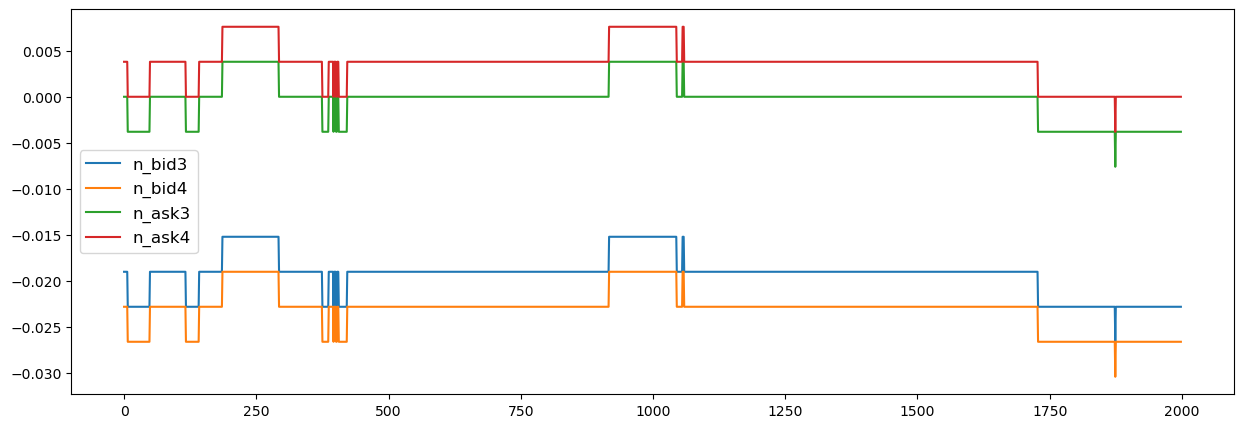

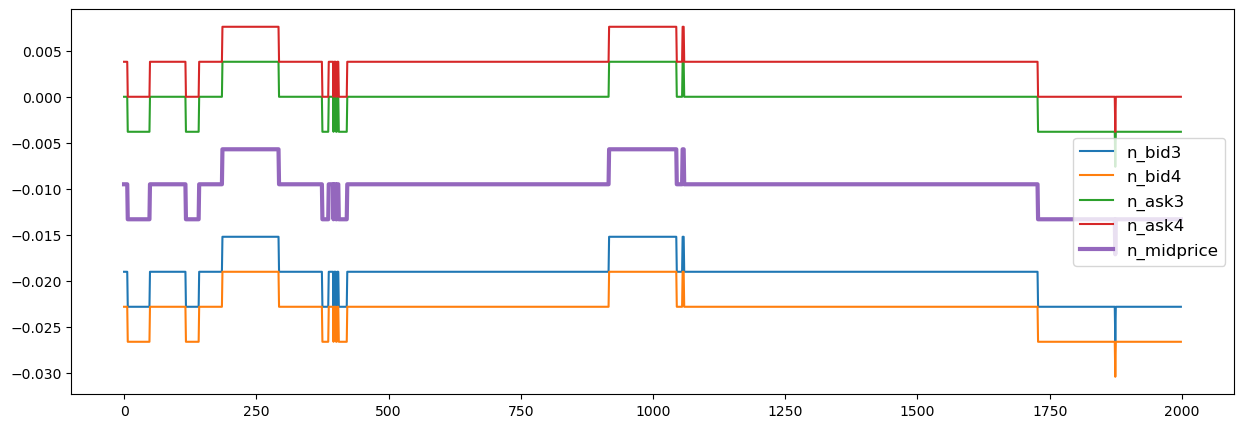

In [93]:
cols = ['n_bid3','n_bid4','n_ask3','n_ask4']
tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[-2000:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
for num, col in enumerate(cols):
    plt.figure(figsize=(15,5))
    plt.subplot(4,1,num+1)
    plt.plot(tmp_df['index'],tmp_df[col], color='red')
    plt.title(col)
plt.show()

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)
plt.legend(fontsize=12)

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)

plt.plot(tmp_df['index'],tmp_df['n_midprice'],label="n_midprice",lw=3)
plt.legend(fontsize=12)

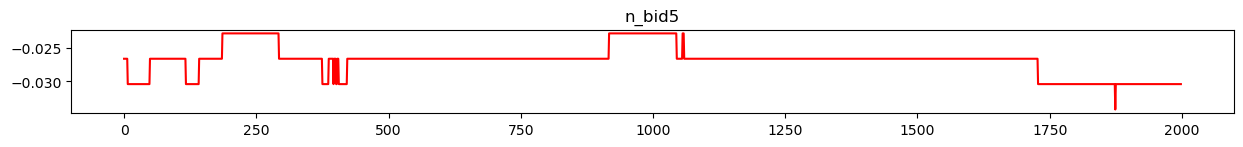

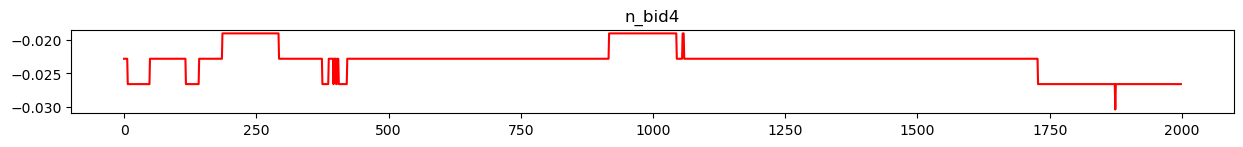

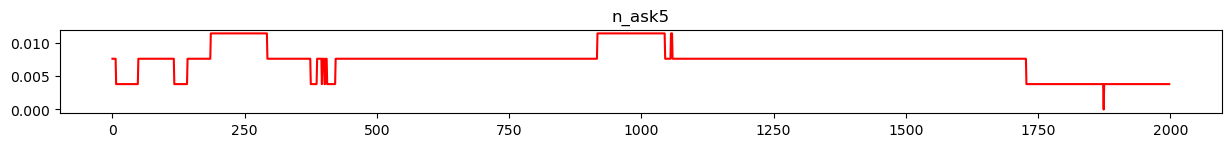

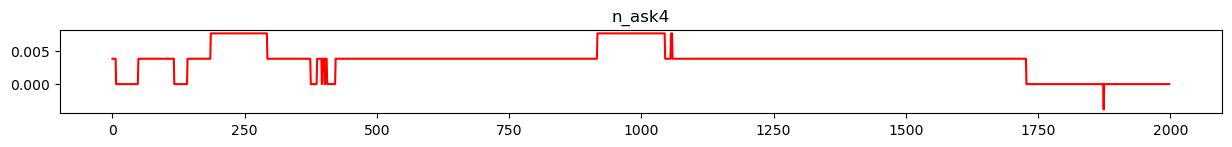

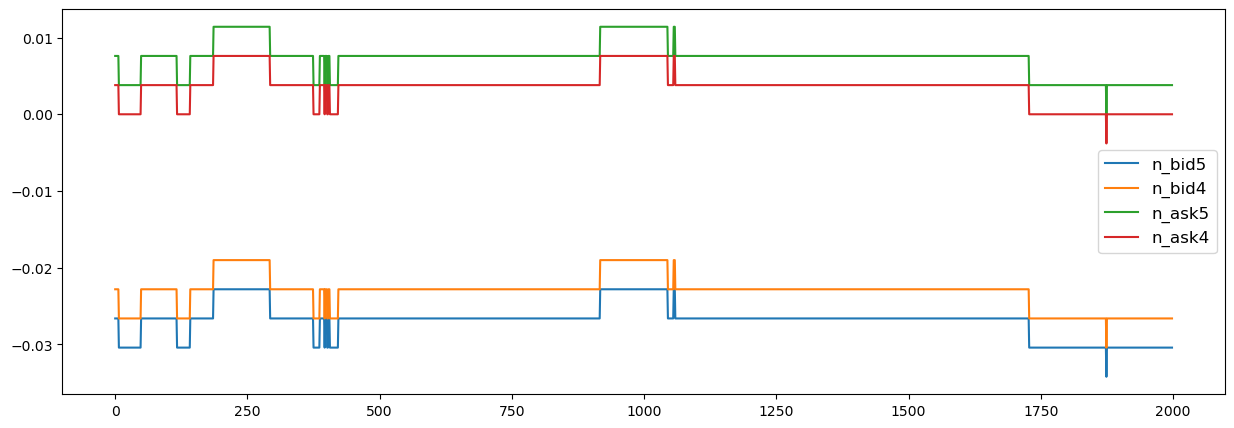

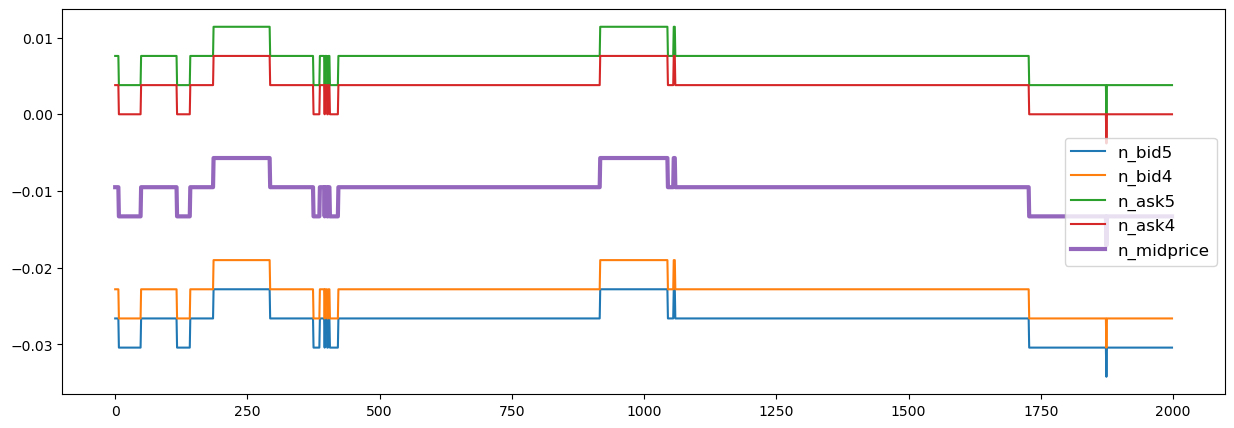

In [94]:
cols = ['n_bid5','n_bid4','n_ask5','n_ask4']
tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[-2000:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
for num, col in enumerate(cols):
    plt.figure(figsize=(15,5))
    plt.subplot(4,1,num+1)
    plt.plot(tmp_df['index'],tmp_df[col], color='red')
    plt.title(col)
plt.show()

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)
plt.legend(fontsize=12)

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)

plt.plot(tmp_df['index'],tmp_df['n_midprice'],label="n_midprice",lw=3)
plt.legend(fontsize=12)

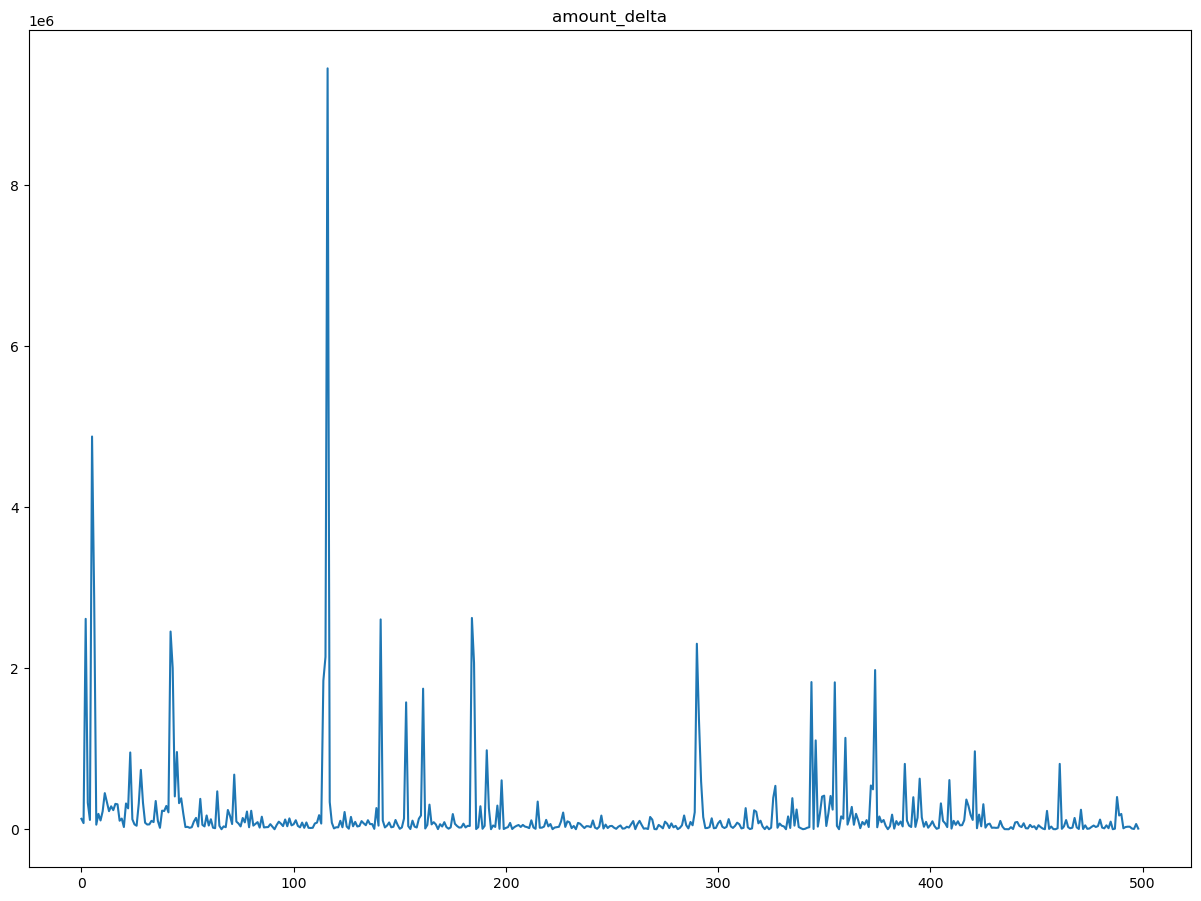

In [95]:
cols = ['amount_delta']
tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[1:500]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
for num, col in enumerate(cols):
    plt.figure(figsize=(15,50))
    plt.subplot(4,1,num+1)
    plt.plot(tmp_df['index'],tmp_df[col])
    plt.title(col)
plt.show()

Text(0, 0.5, 'Price Volatility')

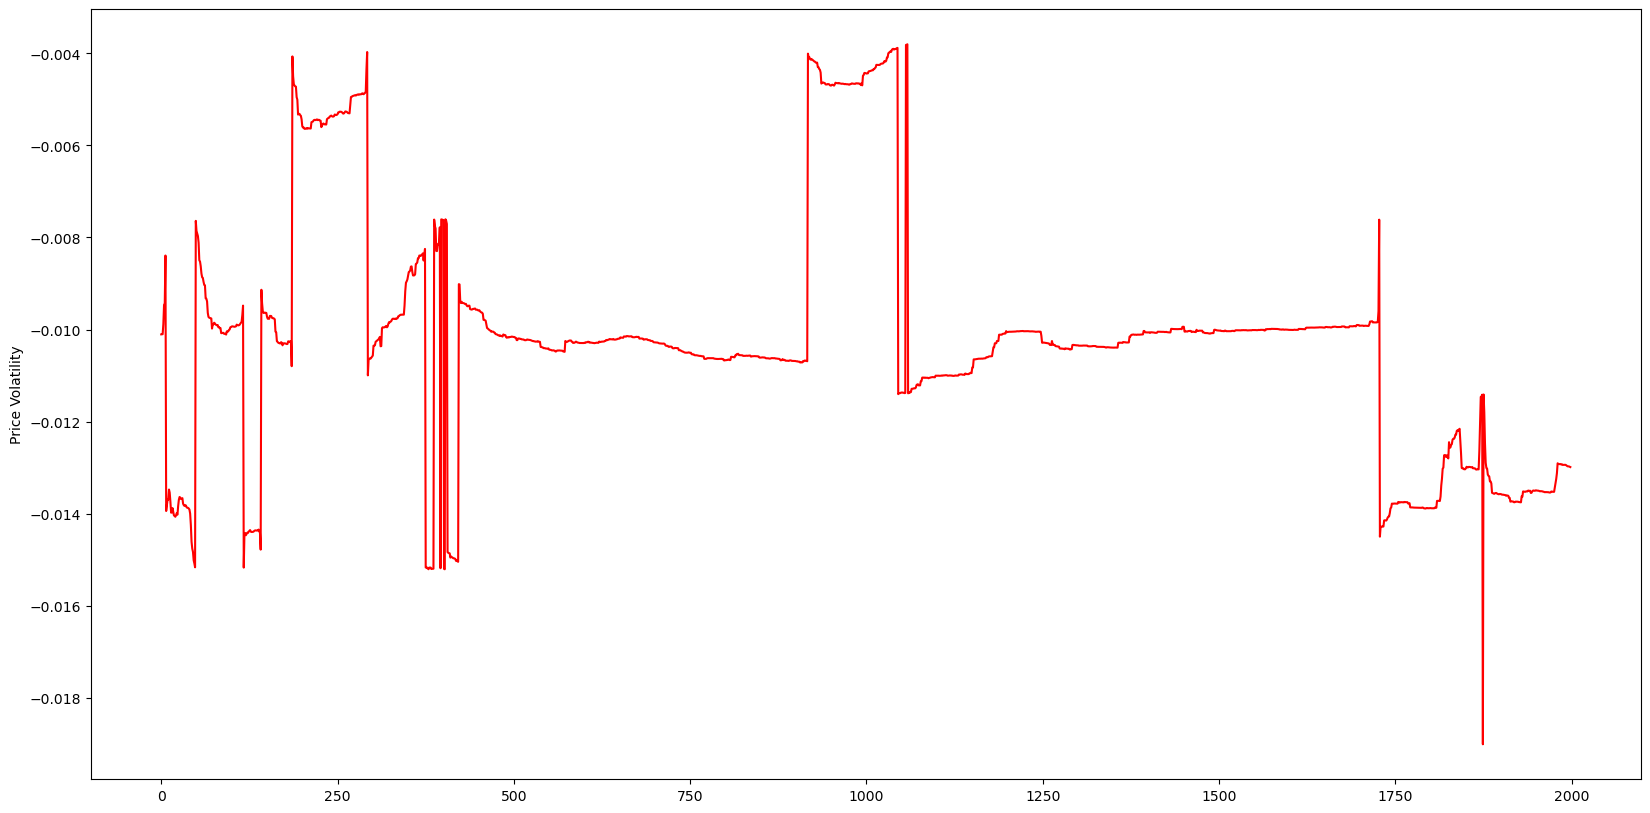

In [96]:
# 波动率是给定股票价格变化的重要统计指标，因此要计算价格变化，我们首先需要在固定间隔进行股票估值。
# 我们将使用已提供的数据的加权平均价格（WAP）进行可视化，WAP的变化反映股票波动情况。
train['wap1'] = (train['n_bid1']*train['n_bsize1'] + train['n_ask1']*train['n_asize1'])/(train['n_bsize1'] + train['n_asize1'])
test['wap1'] = (test['n_bid1']*test['n_bsize1'] + test['n_ask1']*test['n_asize1'])/(test['n_bsize1'] + test['n_asize1'])

tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[-2000:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
plt.figure(figsize=(20,10))
plt.plot(tmp_df['index'], tmp_df['wap1'], color='red')
plt.ylabel('Price Volatility')

In [97]:
# 时间相关特征
train['hour'] = train['time'].apply(lambda x:int(x.split(':')[0]))
test['hour'] = test['time'].apply(lambda x:int(x.split(':')[0]))

train['minute'] = train['time'].apply(lambda x:int(x.split(':')[1]))
test['minute'] = test['time'].apply(lambda x:int(x.split(':')[1]))

# 为了保证时间顺序的一致性，故进行排序
train = train.sort_values(['file','time'])
test = test.sort_values(['file','time'])

# 当前时间特征
# 构建买一卖一和买二卖二相关特征
train['wap1'] = (train['n_bid1']*train['n_bsize1'] + train['n_ask1']*train['n_asize1'])/(train['n_bsize1'] + train['n_asize1'])
test['wap1'] = (test['n_bid1']*test['n_bsize1'] + test['n_ask1']*test['n_asize1'])/(test['n_bsize1'] + test['n_asize1'])

train['wap2'] = (train['n_bid2']*train['n_bsize2'] + train['n_ask2']*train['n_asize2'])/(train['n_bsize2'] + train['n_asize2'])
test['wap2'] = (test['n_bid2']*test['n_bsize2'] + test['n_ask2']*test['n_asize2'])/(test['n_bsize2'] + test['n_asize2'])

train['wap_balance'] = abs(train['wap1'] - train['wap2'])
train['price_spread'] = (train['n_ask1'] - train['n_bid1']) / ((train['n_ask1'] + train['n_bid1'])/2)
train['bid_spread'] = train['n_bid1'] - train['n_bid2']
train['ask_spread'] = train['n_ask1'] - train['n_ask2']
train['total_volume'] = (train['n_asize1'] + train['n_asize2']) + (train['n_bsize1'] + train['n_bsize2'])
train['volume_imbalance'] = abs((train['n_asize1'] + train['n_asize2']) - (train['n_bsize1'] + train['n_bsize2']))

test['wap_balance'] = abs(test['wap1'] - test['wap2'])
test['price_spread'] = (test['n_ask1'] - test['n_bid1']) / ((test['n_ask1'] + test['n_bid1'])/2)
test['bid_spread'] = test['n_bid1'] - test['n_bid2']
test['ask_spread'] = test['n_ask1'] - test['n_ask2']
test['total_volume'] = (test['n_asize1'] + test['n_asize2']) + (test['n_bsize1'] + test['n_bsize2'])
test['volume_imbalance'] = abs((test['n_asize1'] + test['n_asize2']) - (test['n_bsize1'] + test['n_bsize2']))

# 历史平移
# 获取历史信息
for val in ['wap1','wap2','wap_balance','price_spread','bid_spread','ask_spread','total_volume','volume_imbalance']:
    for loc in [1,5,10,20,40,60]:
        train[f'file_{val}_shift{loc}'] = train.groupby(['file'])[val].shift(loc)
        test[f'file_{val}_shift{loc}'] = test.groupby(['file'])[val].shift(loc)
    
# 差分特征
# 获取与历史数据的增长关系
for val in ['wap1','wap2','wap_balance','price_spread','bid_spread','ask_spread','total_volume','volume_imbalance']:
    for loc in [1,5,10,20,40,60]:
        train[f'file_{val}_diff{loc}'] = train.groupby(['file'])[val].diff(loc)
        test[f'file_{val}_diff{loc}'] = test.groupby(['file'])[val].diff(loc)
    
# 窗口统计
# 获取历史信息分布变化信息
# 可以尝试更多窗口大小已经统计方式，如min、max、median等
for val in ['wap1','wap2','wap_balance','price_spread','bid_spread','ask_spread','total_volume','volume_imbalance']:
    train[f'file_{val}_win7_mean'] = train.groupby(['file'])[val].transform(lambda x: x.rolling(window=7, min_periods=3).mean())
    train[f'file_{val}_win7_std'] = train.groupby(['file'])[val].transform(lambda x: x.rolling(window=7, min_periods=3).std())
    
    test[f'file_{val}_win7_mean'] = test.groupby(['file'])[val].transform(lambda x: x.rolling(window=7, min_periods=3).mean())
    test[f'file_{val}_win7_std'] = test.groupby(['file'])[val].transform(lambda x: x.rolling(window=7, min_periods=3).std())


In [98]:
def cv_model(clf, train_x, train_y, test_x, clf_name, seed = 2023):
    folds = 5
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    oof = np.zeros([train_x.shape[0], 3])
    test_predict = np.zeros([test_x.shape[0], 3])
    cv_scores = []
    
    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "xgb":
            # xgboost
            xgb_params = {
              'booster': 'gbtree', 
              'objective': 'multi:softprob',
              'num_class':3,
              'max_depth': 5,
              'lambda': 10,
              'subsample': 0.7,
              'colsample_bytree': 0.7,
              'colsample_bylevel': 0.7,
              'eta': 0.1,
              'tree_method': 'hist',
              'seed': 2023,
              'nthread': 16,
              }
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            test_matrix = clf.DMatrix(test_x)
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(xgb_params, train_matrix, num_boost_round=200, evals=watchlist)
            val_pred  = model.predict(valid_matrix)
            test_pred = model.predict(test_matrix)
            
        if clf_name == "c45":
            # c45决策树
            model = clf(criterion='entropy',splitter='best',max_depth=6)
            model.fit(trn_x, trn_y)
            
            val_pred  = model.predict_proba(val_x)
            test_pred = model.predict_proba(test_x)
        
        if clf_name == "cart":
            # cart决策树
            model = clf(criterion='gini',splitter='best',max_depth=2)
            model.fit(trn_x, trn_y)
            
            val_pred  = model.predict_proba(val_x)
            test_pred = model.predict_proba(test_x)

        oof[valid_index] = val_pred
        test_predict += test_pred / kf.n_splits
        
        F1_score = f1_score(val_y, np.argmax(val_pred, axis=1), average='micro')
        cv_scores.append("%.7f"%F1_score)
        print(cv_scores)
        
    return oof, test_predict

In [99]:
# 处理train_x和test_x中的NaN值
train = train.fillna(0)
test = test.fillna(0)

# 处理train_x和test_x中的Inf值
train = train.replace([np.inf, -np.inf], 0)
test = test.replace([np.inf, -np.inf], 0)

# 入模特征
cols = [f for f in test.columns if f not in ['uuid','time','file']]
for label in ['label_5','label_10','label_20','label_40','label_60']:
    print(f'=================== {label} ===================')
    # 选择c4.5模型
    # c45_oof, c45_test = cv_model(tree.DecisionTreeClassifier, train[cols], train[label], test[cols], 'c45')
    # 选择cart模型
    cart_oof, cart_test = cv_model(tree.DecisionTreeClassifier, train[cols], train[label], test[cols], 'cart')
    # 选择xgboost模型
    # xgb_oof, xgb_test = cv_model(xgb, train[cols], train[label], test[cols], 'xgb')

    # 进行取平均融合
    # final_test = (lgb_test + xgb_test + cat_test) / 3
    # test[label] = np.argmax(final_test, axis=1)

=================== label_5 ===================
************************************ 1 ************************************
['1.0000000']
************************************ 2 ************************************
['1.0000000', '1.0000000']
************************************ 3 ************************************
['1.0000000', '1.0000000', '1.0000000']
************************************ 4 ************************************
['1.0000000', '1.0000000', '1.0000000', '1.0000000']
************************************ 5 ************************************
['1.0000000', '1.0000000', '1.0000000', '1.0000000', '1.0000000']
=================== label_10 ===================
************************************ 1 ************************************
['1.0000000']
************************************ 2 ************************************
['1.0000000', '1.0000000']
************************************ 3 ************************************
['1.0000000', '1.0000000', '1.0000000']
**************

KeyboardInterrupt: 

NameError: name 'train_losses' is not defined

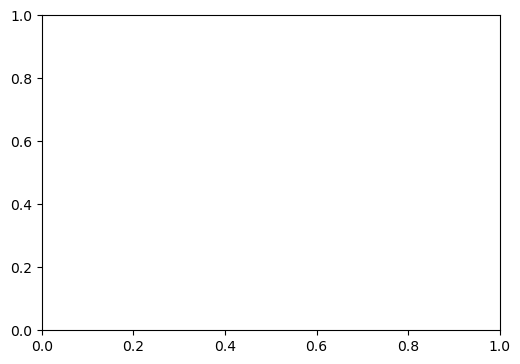

In [ ]:
# 绘制结果

# 设置参数
num_steps = 250
learning_rate = 0.002
l2_coef = 1.0
np.random.seed(2023)

plt.figure(figsize=(13,9))
xticks = np.arange(num_steps) + 1
# 绘制训练曲线
plt.subplot(221)
plt.plot(xticks, train_losses, color='blue', label='train loss')
plt.plot(xticks, test_losses, color='red', ls='--', label='test loss')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(222)
plt.plot(xticks, train_acc, color='blue', label='train accurary')
plt.plot(xticks, test_acc, color='red', ls='--', label='test acc')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()

# 绘制AUC曲线
plt.subplot(223)
plt.plot(xticks, train_auc, color='blue',label='train AUC')
plt.plot(xticks, test_auc, color='red', ls='--', label='test AUC')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
